# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr,spearmanr
import os
from collections import Counter, defaultdict
import re
from random import choice
from itertools import groupby, chain
from operator import itemgetter
import os
from randseq.utils import revcomp, calculate_log2fc, allseqs, get_all_sites, flatten    

In [ ]:
#| hide
from randseq.example_data import get_example_data_dir

In [ ]:
#| hide
data_path=get_example_data_dir()
os.listdir(data_path)

['__init__.py', 'countsTable.csv', '__pycache__']

### 1. Computing the log2fc of the sequences from counts data

In [ ]:
counts_file="countsTable.csv"
file_path=os.path.join(data_path,counts_file)
counts=pd.read_csv(file_path, index_col=0)
counts = counts[[col for col in counts.columns if ("_T0" in col) or ("MFDpir" in col)]]

log2fc_df = calculate_log2fc(counts, reference_column='MFDpir', count_threshold=20, pseudocount=1)
log2fc_df.head()

,K12_T0,HS_T0,E1114_T0,E1167_T0,H120_T0,TA054_T0,TA447_T0,E101_T0,41-1Ti9_T0,TA280_T0,M114_T0,TA249_T0,ROAR8_T0,JJ1886_T0,CFT073_T0,APECO1_T0,UTI89_T0,S88_T0,MG1655_T0
CGGAGGTACTGGGTACATTT,0.043818,0.049551,0.187868,-0.302314,0.238304,0.051836,0.186450,0.093344,0.029484,0.106924,-0.329062,-0.102645,0.144280,0.084854,0.212674,0.229591,-0.457070,0.213624,0.090458
TGGCGATAATGCCGGCTATC,0.045463,0.137127,0.437387,0.113014,0.137767,0.060845,0.063668,-0.014449,-0.008977,-0.025606,0.003605,0.084441,-0.167417,0.018354,0.041919,0.016410,-0.207488,0.092292,0.101627
TTCCAGTTCACTGGTCTTCG,-0.049694,0.049903,-0.105148,-0.061620,-0.081886,-0.072083,0.402207,0.087885,0.207649,0.127306,0.204781,-0.106153,-0.012804,0.285761,-0.167107,0.269887,0.182096,0.458076,0.128330
AATTTCAGTGCCGTTCAGAT,-0.251957,-0.422224,-0.224591,-0.058728,-0.204575,-0.192908,-0.220676,-0.143054,-0.277042,-0.205084,0.058866,-0.064442,-0.029019,-0.042375,-0.095307,-0.254714,0.460256,-0.183890,-0.180938
CTGCGGTAATAATTCCCGCC,-0.178427,-0.154025,0.581087,0.401967,0.047002,-0.309751,-0.200689,-0.292042,-0.473919,-0.298991,-0.221896,-0.060500,0.085888,-0.279165,-0.206676,-0.097563,-0.347949,-0.188758,-0.186226


### 2. Obtaining the sequence context of the variable sequence to identify sites at the boundaries of the variable sequence

In [ ]:
#| export
def get_lib_seq_context(seqs,left,right):
    """
    Generates a list of sequences by combining a left and right sequence with each sequence in the input list.
    
    Args:
        seqs (list): List of sequences to be combined.
        left (str): Left sequence to prepend.
        right (str): Right sequence to append.

    Returns:
        list: List of combined sequences.
    """
    left=left.upper()
    right=right.upper()
    lib=[left+r+right for r in seqs]
    return lib


In [ ]:
left, right = "gtgctaggtataatactagt", "atccactagtccctttacgc"
lib=get_lib_seq_context(log2fc_df.index,left,right)
lib[:5]

['GTGCTAGGTATAATACTAGTCGGAGGTACTGGGTACATTTATCCACTAGTCCCTTTACGC',
 'GTGCTAGGTATAATACTAGTTGGCGATAATGCCGGCTATCATCCACTAGTCCCTTTACGC',
 'GTGCTAGGTATAATACTAGTTTCCAGTTCACTGGTCTTCGATCCACTAGTCCCTTTACGC',
 'GTGCTAGGTATAATACTAGTAATTTCAGTGCCGTTCAGATATCCACTAGTCCCTTTACGC',
 'GTGCTAGGTATAATACTAGTCTGCGGTAATAATTCCCGCCATCCACTAGTCCCTTTACGC']

### 3. Listing all the sequence motifs found in our library that follow a specific pattern 

The pattern is a list of 3 numbers:
1. The number of defined bases in the first part of the site  
2. The number of undefined bases in the middle  
3. The number of defined bases in the second part of the site

In [ ]:
#| export
     
def get_sites_in_seq(lib,pattern=(3,6,4),no_ori=True):
    '''Computes the list of unique sites matching the pattern present in each sequence of the library
    The pattern is a list of 3 number:
        1. The number of defined bases in the first part of the site
        2. The number of undefined bases in the middle
        3. The number of defined bases in the second part of the site
    '''
    #Checks all sequences are the same size
    if len(set([len(s) for s in lib]))!=1:
        return 'not all sequences in library are the same size'
    
    L=len(lib[0])
    
    if len(pattern)>L:
        return 'site specifications are longer than the sequence provided'
    
    
    set_list=[]
    for seq in lib:
        sites=re.findall("(?=([ATGC]{{{}}})([ATGC]{{{}}})([ATGC]{{{}}}))".format(pattern[0],pattern[1],pattern[2]),seq)
        if no_ori==True:
            rev=revcomp(seq)
            sites+=re.findall("(?=([ATGC]{{{}}})([ATGC]{{{}}})([ATGC]{{{}}}))".format(pattern[0],pattern[1],pattern[2]),rev)
        set_list.append(set([s1+'N'*pattern[1]+s3 for s1,s2,s3 in sites]))

    return set_list

In [ ]:
left, right = "gtgctaggtataatactagt", "atccactagtccctttacgc"
lib=get_lib_seq_context(log2fc_df.index,left,right)
sites_in_seq=get_sites_in_seq(lib,pattern=(3,6,4),no_ori=True)
assert len(sites_in_seq) == len(lib)
print(f"First 5 pattern matching sequences found in the first sequence of the library:")
list(sites_in_seq[0])[:5]

First 5 pattern matching sequences found in the first sequence of the library:


['TACNNNNNNCATT',
 'ATTNNNNNNCTAG',
 'TTANNNNNNAGTC',
 'TAGNNNNNNACCT',
 'CACNNNNNNCTTT']

In [ ]:
#| export
def score(FCs, thr=-1):
    """
    Returns the fraction of sequences depleted below the thr value.
    Handles empty lists of FCs by returning 0.
    """
    if len(FCs)==0:  # Check if the list is empty
        return 0.0
    return sum([x < thr for x in FCs]) / len(FCs)

In [ ]:
assert score([-2,-0.5,-0.1,-5],thr=-1) == 0.5

In [ ]:
#| export
def identify_depleted_motifs_scanning_ends(log2fc_series, scan_depth_k=6, max_motif_length=6, depletion_threshold=-1, score_thr=0.8, min_sequence_support=5):
    """
    Identifies DNA motifs associated with sequence depletion by scanning k positions
    from both the left and right ends of sequences, using a pandas Series of log2FC values.

    Args:
        log2fc_series (pd.Series): pandas Series with sequences (DNA strings) as index
                                   and log2FC values as data.
        scan_depth_k (int): The number of positions to scan from each end (0 to k inclusive).
        max_motif_length (int): The maximum length of the motif to consider.
        depletion_threshold (float): The log2FC threshold for considering a sequence depleted.
        min_sequence_support (int): The minimum number of sequences (strictly greater than this value)
                                    a motif must be found in to be included in the results.

    Returns:
        pd.DataFrame: A DataFrame with identified motifs, their length, actual 0-indexed position,
                      number of occurrences, average log2FC, and depletion score (fraction_depleted).
                      Sorted by primary depletion metrics.
    """
    if not isinstance(log2fc_series, pd.Series):
        print(f"Error: Input must be a pandas Series.")
        return pd.DataFrame(columns=['motif', 'length', 'position', 'num_sequences', 'avg_log2fc', 'fraction_depleted'])

    if log2fc_series.empty:
        print(f"Error: Input Series is empty.")
        return pd.DataFrame(columns=['motif', 'length', 'position', 'num_sequences', 'avg_log2fc', 'fraction_depleted'])

    current_log2fc_series = pd.to_numeric(log2fc_series.copy(), errors='coerce')
    series_name = current_log2fc_series.name if current_log2fc_series.name else "input Series"
    print(f"Analyzing motifs of length 1 to {max_motif_length}, scanning positions 0 to {scan_depth_k} from each end, for {series_name}.")
    print(f"Minimum sequence support for a motif: > {min_sequence_support} (i.e., {min_sequence_support +1} or more)")


    motif_stats_accumulator = {}

    # Iterate over (sequence_string, log2fc_value) pairs
    for seq_str, log2fc_val in current_log2fc_series.items(): 
        if pd.isna(log2fc_val) or not isinstance(seq_str, str):
            continue

        processed_positions_for_this_seq = set() 
        for motif_len in range(1, max_motif_length + 1):
            if len(seq_str) < motif_len:
                continue

            # Left scans
            for j_offset in range(scan_depth_k + 1):
                actual_pos_left = j_offset
                if actual_pos_left + motif_len <= len(seq_str):
                    if (actual_pos_left, motif_len) not in processed_positions_for_this_seq:
                        motif = seq_str[actual_pos_left : actual_pos_left + motif_len]
                        key = (motif, actual_pos_left, motif_len) 
                        if key not in motif_stats_accumulator:
                            motif_stats_accumulator[key] = []
                        motif_stats_accumulator[key].append(log2fc_val)
                        processed_positions_for_this_seq.add((actual_pos_left, motif_len))

            # Right scans
            for j_offset in range(scan_depth_k + 1):
                actual_pos_right = len(seq_str) - motif_len - j_offset
                if actual_pos_right >= 0 and actual_pos_right + motif_len <= len(seq_str):
                    if (actual_pos_right, motif_len) not in processed_positions_for_this_seq:
                        motif = seq_str[actual_pos_right : actual_pos_right + motif_len]
                        key = (motif, actual_pos_right, motif_len) 
                        if key not in motif_stats_accumulator:
                            motif_stats_accumulator[key] = []
                        motif_stats_accumulator[key].append(log2fc_val)
                        processed_positions_for_this_seq.add((actual_pos_right, motif_len))
    
    if not motif_stats_accumulator:
        print("No motifs found or no valid data to process based on scan parameters.")
        return pd.DataFrame(columns=['motif', 'length', 'position', 'num_sequences', 'avg_log2fc', 'fraction_depleted'])

    # Use a list comprehension for conciseness
    results = [
        {
            'motif': key[0],             # motif_str
            'length': key[2],            # motif_len
            'position': key[1],          # actual_pos
            'num_sequences': len(fc_values_list), 
            'avg_log2fc': np.mean(fc_values_list),
            'fraction_depleted': score(fc_values_list, depletion_threshold)
        }
        for key, fc_values_list in motif_stats_accumulator.items()
        if len(fc_values_list) > min_sequence_support # Apply min_sequence_support filter
    ]
    
    if not results:
        print(f"No motifs found meeting the minimum sequence support of > {min_sequence_support}.")
        return pd.DataFrame(columns=['motif', 'length', 'position', 'num_sequences', 'avg_log2fc', 'fraction_depleted'])

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(
        by=['fraction_depleted', 'avg_log2fc', 'num_sequences'],
        ascending=[False, True, False]
    )
    results_df = results_df.loc[results_df['fraction_depleted'] > score_thr]
    return results_df

In [ ]:
depleted_motifs_df=identify_depleted_motifs_scanning_ends(log2fc_df["JJ1886_T0"])
depleted_motifs_df.head(10)

Analyzing motifs of length 1 to 6, scanning positions 0 to 6 from each end, for JJ1886_T0.
Minimum sequence support for a motif: > 5 (i.e., 6 or more)


,motif,length,position,num_sequences,avg_log2fc,fraction_depleted
8695,AAAAG,5,11,10,-5.662158,1.0
22013,GTGCGG,6,0,6,-5.490821,1.0
12567,AAAGT,5,12,13,-5.262390,1.0
12568,CAAAG,5,11,16,-5.201596,1.0
17472,GTGCG,5,0,10,-5.107176,1.0
2571,AAAG,4,12,42,-5.076919,1.0
2580,AAAGC,5,12,9,-5.029139,1.0
17128,AAAGA,5,12,13,-4.996286,1.0
10197,GTGTC,5,0,6,-4.959089,1.0
23364,AAAGG,5,12,7,-4.943650,1.0


In [ ]:
#| export
def filter_to_core_motifs(depleted_motifs_df, 
                          score_improvement_margin=0.05):
    """
    Filters a DataFrame of depleted motifs to identify underlying "core" motifs.
    A longer motif is kept only if it's significantly better than a shorter core motif it contains.

    Args:
        depleted_motifs_df (pd.DataFrame): DataFrame from identify_depleted_motifs_scanning_ends.
        score_improvement_margin (float): A longer motif's 'fraction_depleted' must be
                                          greater than the core motif's score by this margin.
        fc_improvement_margin (float): A longer motif's 'avg_log2fc' must be lower
                                       than the core motif's avg_log2fc by this margin.

    Returns:
        pd.DataFrame: A filtered DataFrame containing potentially core motifs.
    """
    if depleted_motifs_df.empty:
        return pd.DataFrame(columns=depleted_motifs_df.columns)

    sorted_df = depleted_motifs_df.sort_values(
        by=['length','fraction_depleted'],
        ascending=[True, False]
    ).reset_index(drop=True)

    core_motifs_list = []
    
    for idx, candidate_row in sorted_df.iterrows():
        candidate_motif = candidate_row['motif']
        candidate_pos = candidate_row['position']
        candidate_len = candidate_row['length']
        candidate_score = candidate_row['fraction_depleted']
        candidate_avg_fc = candidate_row['avg_log2fc']
        
        is_subsumed = False
        for core_dict in core_motifs_list: 
            core_motif = core_dict['motif']
            core_pos = core_dict['position']
            core_len = core_dict['length']
            core_score = core_dict['fraction_depleted']
            core_avg_fc = core_dict['avg_log2fc']
            
            if core_len < candidate_len and core_motif in candidate_motif:    
                relative_start = candidate_motif.find(core_motif)
                if candidate_pos + relative_start == core_pos:
                    significantly_better_score = candidate_score >= core_score - score_improvement_margin
                        
                    if significantly_better_score:
                        is_subsumed = True
                        break 
        
        if not is_subsumed:
            core_motifs_list.append(candidate_row.to_dict())
            
    if not core_motifs_list:
         return pd.DataFrame(columns=depleted_motifs_df.columns)
    return pd.DataFrame(core_motifs_list)



In [ ]:
depleted_motifs_df=filter_to_core_motifs(depleted_motifs_df)
depleted_motifs_df.head(10)

,motif,length,position,num_sequences,avg_log2fc,fraction_depleted
0,GTG,3,0,187,-4.764500,1.000000
1,AAAG,4,12,42,-5.076919,1.000000
2,TGGTAT,6,1,6,-3.944828,0.833333


In [ ]:
#| export
def plot_analysis_results(counts_df, sample_col, ref_col, log2fc_series_for_dist, core_motifs_df, 
                               title_scatter="Normalized Sequence Counts Comparison (Log Scale)", 
                               title_dist="Log2FC Distribution", pseudocount=1):
    """
    Generates two plots:
    1. Scatter plot of normalized sample vs reference counts (log scale),
       highlighting sequences containing core motifs with distinct colors.
    2. Histogram of log2FC values, with an overlay for sequences containing specific core motifs.

    Args:
        counts_df (pd.DataFrame): DataFrame with sequences as index and count columns.
        sample_col (str): Name of the column for sample counts (y-axis).
        ref_col (str): Name of the column for reference counts (x-axis).
        log2fc_series_for_dist (pd.Series): Series with sequences as index and log2FC values
                                            for the distribution plot.
        core_motifs_df (pd.DataFrame): DataFrame of core motifs, must include
                                       'motif', 'position', and 'length' columns.
        title_scatter (str): The title for the scatter plot.
        title_dist (str): The title for the log2FC distribution plot.
        pseudocount (int/float): Value to add to counts before log transformation for scatter.
    """
    # --- Scatter Plot of Normalized Counts ---
    if not isinstance(counts_df, pd.DataFrame) or counts_df.empty:
        print("Plotting error: counts_df is invalid or empty for scatter plot.")
        return
    if sample_col not in counts_df.columns or ref_col not in counts_df.columns:
        print(f"Plotting error: One or both count columns ('{sample_col}', '{ref_col}') not in counts_df.")
        return

    expected_core_motif_cols = ['motif', 'position', 'length']
    if core_motifs_df is None:
        core_motifs_df = pd.DataFrame(columns=expected_core_motif_cols)
    elif not isinstance(core_motifs_df, pd.DataFrame):
        print("Plotting warning: core_motifs_df was not a DataFrame. No motif highlights will be applied.")
        core_motifs_df = pd.DataFrame(columns=expected_core_motif_cols)
    elif not core_motifs_df.empty and not all(col in core_motifs_df.columns for col in expected_core_motif_cols):
        print(f"Plotting warning: core_motifs_df is missing one or more required columns ({', '.join(expected_core_motif_cols)}). No motif highlights will be applied.")
        core_motifs_df = pd.DataFrame(columns=expected_core_motif_cols)

    sample_counts_numeric = pd.to_numeric(counts_df[sample_col], errors='coerce')
    ref_counts_numeric = pd.to_numeric(counts_df[ref_col], errors='coerce')
    total_sample_counts = sample_counts_numeric.sum()
    total_ref_counts = ref_counts_numeric.sum()

    if total_sample_counts == 0 or total_ref_counts == 0:
        print("Plotting warning: Total counts for sample or reference are zero. Using raw counts + pseudocount for scatter plot.")
        x_data_norm = ref_counts_numeric.fillna(0).values + pseudocount
        y_data_norm = sample_counts_numeric.fillna(0).values + pseudocount
        norm_label_suffix = f"(Counts + {pseudocount}, log scale) - Normalization to CPM failed"
    else:
        x_data_norm = (ref_counts_numeric / total_ref_counts * 1e6).fillna(0).values + pseudocount
        y_data_norm = (sample_counts_numeric / total_sample_counts * 1e6).fillna(0).values + pseudocount
        norm_label_suffix = f"(CPM + {pseudocount}, log scale)"

    default_color = 'grey' 
    motif_color_map = {}
    if not core_motifs_df.empty and 'motif' in core_motifs_df.columns:
        unique_motif_strings = core_motifs_df['motif'].unique()
        if len(unique_motif_strings) > 0:
            cmap = plt.cm.get_cmap('tab10') 
            motif_color_map = {
                motif_str: cmap(i % cmap.N) 
                for i, motif_str in enumerate(unique_motif_strings)
            }

    point_assigned_motif_str_scatter = [None] * len(counts_df)
    if not core_motifs_df.empty and all(col in core_motifs_df.columns for col in expected_core_motif_cols):
        for i, seq_str in enumerate(counts_df.index):
            if not isinstance(seq_str, str): continue
            for _, motif_row in core_motifs_df.iterrows():
                current_motif_str = motif_row['motif']
                try:
                    position = int(motif_row['position']); motif_len = int(motif_row['length'])   
                except (ValueError, TypeError): continue
                if current_motif_str in motif_color_map:
                    if len(seq_str) >= position + motif_len:
                        if seq_str[position : position + motif_len] == current_motif_str:
                            point_assigned_motif_str_scatter[i] = current_motif_str
                            break 
    
    plt.figure(figsize=(12, 8))
    other_x_scatter = [x_data_norm[i] for i, m_str in enumerate(point_assigned_motif_str_scatter) if m_str is None and pd.notna(x_data_norm[i]) and pd.notna(y_data_norm[i])]
    other_y_scatter = [y_data_norm[i] for i, m_str in enumerate(point_assigned_motif_str_scatter) if m_str is None and pd.notna(x_data_norm[i]) and pd.notna(y_data_norm[i])]
    if other_x_scatter:
        plt.scatter(other_x_scatter, other_y_scatter, color=default_color, alpha=0.5, s=20, label='Other sequences')

    plotted_motifs_legend_scatter = False
    if motif_color_map:
        for motif_to_plot, color_for_motif in motif_color_map.items():
            motif_x = [x_data_norm[i] for i, m_str in enumerate(point_assigned_motif_str_scatter) if m_str == motif_to_plot and pd.notna(x_data_norm[i]) and pd.notna(y_data_norm[i])]
            motif_y = [y_data_norm[i] for i, m_str in enumerate(point_assigned_motif_str_scatter) if m_str == motif_to_plot and pd.notna(x_data_norm[i]) and pd.notna(y_data_norm[i])]
            if motif_x:
                plt.scatter(motif_x, motif_y, color=color_for_motif, alpha=0.7, s=30, label=f'Motif: {motif_to_plot}')
                plotted_motifs_legend_scatter = True
        
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(f"{ref_col} {norm_label_suffix}")
    plt.ylabel(f"{sample_col} {norm_label_suffix}")
    plt.title(depleted_motifs_df)
    
    valid_x_for_line_norm = x_data_norm[(x_data_norm > 0) & np.isfinite(x_data_norm)]
    valid_y_for_line_norm = y_data_norm[(y_data_norm > 0) & np.isfinite(y_data_norm)]
    if len(valid_x_for_line_norm) > 0 and len(valid_y_for_line_norm) > 0:
        min_val_norm = min(np.min(valid_x_for_line_norm), np.min(valid_y_for_line_norm))
        max_val_norm = max(np.max(valid_x_for_line_norm), np.max(valid_y_for_line_norm))
        if min_val_norm < max_val_norm : 
             plt.plot([min_val_norm, max_val_norm], [min_val_norm, max_val_norm], 'k--', alpha=0.7, label='y=x (No change)')
    
    handles_scatter, labels_scatter = plt.gca().get_legend_handles_labels()
    if handles_scatter:
        by_label_scatter = dict(zip(labels_scatter, handles_scatter))
        plt.legend(by_label_scatter.values(), by_label_scatter.keys())
    elif not plotted_motifs_legend_scatter and other_x_scatter:
         print("Plotting info (Scatter): No sequences with core motifs found/plotted to highlight.")
    elif not other_x_scatter and not plotted_motifs_legend_scatter:
         print("Plotting error (Scatter): No valid data points to plot.")
    plt.grid(True, linestyle=':', alpha=0.7); plt.tight_layout(); plt.show()

    # --- Log2FC Distribution Plot ---
    if not isinstance(log2fc_series_for_dist, pd.Series) or log2fc_series_for_dist.empty:
        print("Plotting error: log2fc_series_for_dist is invalid or empty for distribution plot.")
        return 
    
    all_log2fc_values = pd.to_numeric(log2fc_series_for_dist, errors='coerce').dropna().values

    plt.figure(figsize=(10, 6))
    if len(all_log2fc_values) > 0:
        # Plot all sequences distribution first
        plt.hist(all_log2fc_values, bins=50, alpha=0.5, label='All sequences', color='lightgrey', density=True)
    else:
        print("Log2FC Distribution: No data for 'All sequences'.")

    # Plot distributions for each core motif
    plotted_motif_dist = False
    if not core_motifs_df.empty and all(col in core_motifs_df.columns for col in expected_core_motif_cols) and motif_color_map:
        # Iterate through unique motifs found in the core_motifs_df, using the motif_color_map
        for motif_to_plot, color_for_motif in motif_color_map.items():
            # Find all rows in core_motifs_df that match this motif_to_plot
            # A motif string can appear at different positions/lengths but we group by motif string here
            
            log2fc_for_this_motif_list = []
            # Get all sequences that contain this specific motif_to_plot (considering its position and length from core_motifs_df)
            # This requires iterating through core_motifs_df and then through sequences for each matching motif entry.
            
            # A more direct way: find all sequences containing this motif string at ANY of its core-identified positions
            sequences_containing_this_motif_str_mask = pd.Series(False, index=log2fc_series_for_dist.index)
            
            # Get all (position, length) pairs for the current motif_to_plot from core_motifs_df
            motif_instances = core_motifs_df[core_motifs_df['motif'] == motif_to_plot]

            for seq_idx, seq_str_from_log2fc in enumerate(log2fc_series_for_dist.index):
                if not isinstance(seq_str_from_log2fc, str): continue
                found_this_motif_in_seq = False
                for _, motif_instance_row in motif_instances.iterrows():
                    try:
                        pos = int(motif_instance_row['position'])
                        mlen = int(motif_instance_row['length'])
                    except (ValueError, TypeError): continue

                    if len(seq_str_from_log2fc) >= pos + mlen:
                        if seq_str_from_log2fc[pos : pos + mlen] == motif_to_plot:
                            sequences_containing_this_motif_str_mask.iloc[seq_idx] = True
                            found_this_motif_in_seq = True
                            break # Found this motif string in this sequence
                # if found_this_motif_in_seq: # not needed, mask handles it
                #    pass
            
            log2fc_values_for_this_motif = pd.to_numeric(log2fc_series_for_dist[sequences_containing_this_motif_str_mask], errors='coerce').dropna().values
            
            if len(log2fc_values_for_this_motif) > 0:
                plt.hist(log2fc_values_for_this_motif, bins=50, alpha=0.6, label=f'Motif: {motif_to_plot}', color=color_for_motif, density=True)
                plotted_motif_dist = True
    
    if not plotted_motif_dist and len(all_log2fc_values) > 0 : # if only 'all sequences' was plotted
        print("Log2FC Distribution: No specific core motifs to plot or no sequences found for them.")
    elif not plotted_motif_dist and len(all_log2fc_values) == 0:
         print("Log2FC Distribution: No data to plot.")


    plt.xlabel("Log2 Fold Change (log2FC)")
    plt.ylabel("Density")
    plt.title(title_dist)
    if len(all_log2fc_values) > 0 or plotted_motif_dist: # Show legend if there's data
        plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_86001/2090320408.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


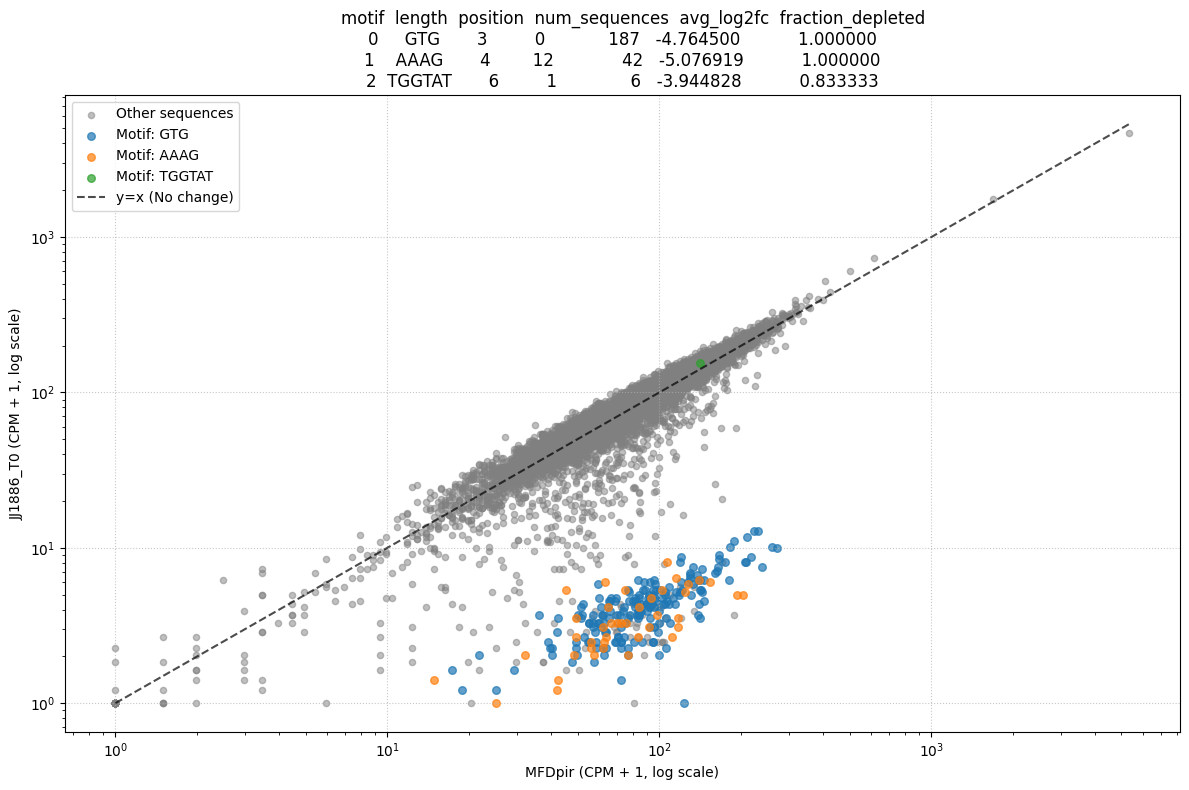

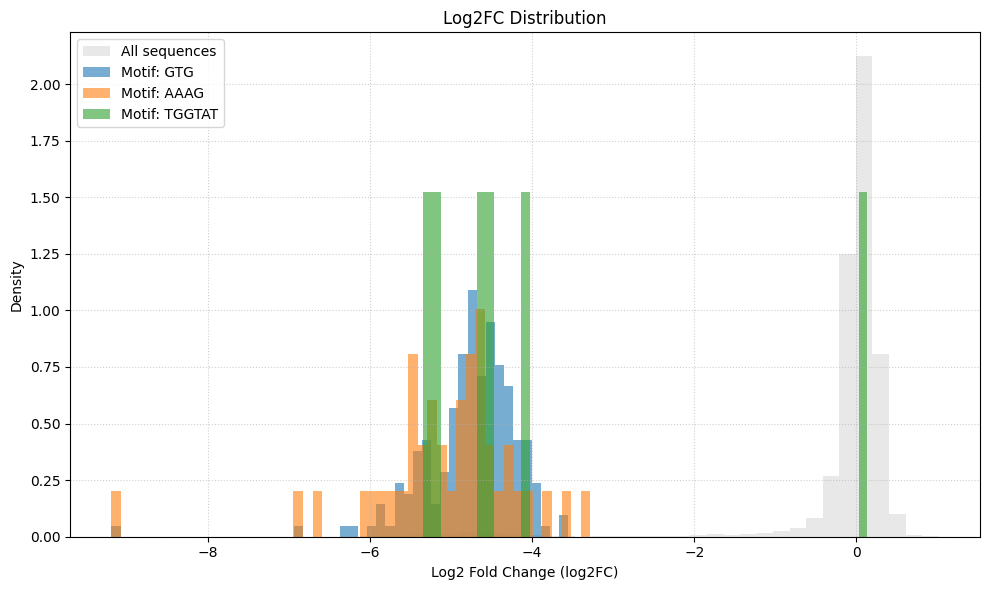

In [ ]:
plot_analysis_results(counts,"JJ1886_T0","MFDpir", log2fc_df["JJ1886_T0"], depleted_motifs_df)

In [ ]:
#| export
def get_fold_change_values_per_site(site_sets_list, fold_changes_list):
    """
    Computes a dictionary mapping each unique site to a list of its associated
    log2 Fold Change (FC) values.

    Args:
        site_sets_list (list): A list of sets, where each set contains the sequence motifs found in a member of the library.
        fold_changes_list (list): A list of log2FC values, corresponding to each
                                  sequence in the library.

    Returns:
        dict: A dictionary where keys are sequence motifs and values are numpy arrays
              containing the log2FC values associated with that site.
    """

    # Step 1: Create a flat list of (site, FC_value) pairs
    # Each site within a set is associated with that set's FC value.
    site_fc_pairs_nested = [
     [(site, fc_value) for site in site_set]
     for site_set, fc_value in zip(site_sets_list, fold_changes_list)
     ]
    site_fc_pairs = list(chain.from_iterable(site_fc_pairs_nested)) # Standard way to flatten

    # Step 2: Sort the pairs by site to prepare for grouping
    # Sorting is essential for groupby to work correctly.
    site_fc_pairs.sort(key=itemgetter(0)) # Sorts by the first element (site)

    # Step 3: Group by site and collect FC values
    site_to_fcs_map = {}
    for site, group in groupby(site_fc_pairs, key=itemgetter(0)):
        # group is an iterator of (site, fc_value) tuples for the current site
        # Extract the FC value (the second element) from each pair in the group
        fcs_for_site = np.array([fc_value for current_site, fc_value in group])
        site_to_fcs_map[site] = fcs_for_site

    return site_to_fcs_map


In [ ]:
pattern=(3,6,4)
set_list=get_sites_in_seq(lib,pattern=pattern,no_ori=True)
site_FCs=get_fold_change_values_per_site(set_list,log2fc_df["JJ1886_T0"].values)
site_FCs


{'AAANNNNNNAAAA': array([ 0.13962831,  0.34813015,  0.14204574,  0.07821357, -0.00238024,
         0.1021536 , -0.00612473,  0.2100328 ,  0.2962744 ,  0.0025432 ,
         0.3188645 ,  0.03958058,  0.2728456 ,  0.1021536 , -0.00822014,
         0.1805415 ,  0.40419008,  0.13095947, -0.2034691 , -0.31297006,
        -0.09283485,  0.1805415 ,  0.03343721,  0.01871935,  0.15062592,
         0.01992528, -0.28307618, -0.01910697, -0.1061719 ,  0.29174406,
         0.02519496, -1.16860806,  0.18599593,  0.03379413, -0.07695472,
         0.25243442,  0.11851977,  0.05618116,  0.35471597]),
 'AAANNNNNNAAAC': array([ 7.60109166e-02,  4.14458905e-02,  2.00768279e-02,  3.06460696e-02,
         1.97143467e-01,  6.91202175e-02,  5.92352039e-02,  3.08485674e-02,
         9.42958373e-03,  2.19221968e-01, -2.01768784e-02,  2.92751004e-01,
        -2.78172258e-02, -4.82745129e+00, -3.36375613e-01,  1.66327641e-01,
        -2.37853829e-02,  5.04809596e-02,  1.87330666e-01,  2.96274401e-01,
        -1.00

In [ ]:
#| export
def get_sites_scores(site_FCs, pattern, log2FC_thr=-1):
    allsites=get_all_sites(pattern)
    site_scores=dict([(s,(0,0)) for s in allsites])
    sites_with_no_data=[]
    for site in allsites:
        if site in site_FCs:
            site_scores[site]=(score(site_FCs[site], log2FC_thr), len(site_FCs[site]))
        else:
            sites_with_no_data.append(site)
    return site_scores

In [ ]:
site_scores = get_sites_scores(site_FCs,pattern)
[(site,site_scores[site]) for site in site_scores 
                         if (site_scores[site][0]>0.8)
                         and site_scores[site][1]>5
]

[('AATNNNNNNGTGT', (np.float64(0.8695652173913043), 46)),
 ('AATNNNNNNGTGG', (np.float64(0.8412698412698413), 63)),
 ('AATNNNNNNGTGC', (np.float64(0.8269230769230769), 52)),
 ('TAANNNNNNTGTG', (np.float64(0.9545454545454546), 198)),
 ('CACNNNNNNATTA', (np.float64(0.9447236180904522), 199))]

In [ ]:
#| export
def find_restricted_sites(FCs, left, right, patterns=[(6,0,0),(3,6,4)], log2FC_thr=-1, fraction_thr=0.8, min_count=5):
  
    lib = get_lib_seq_context(FCs.index, left, right)
    restricted_sites={}
    for pattern in patterns:
        print("Looking for sites following pattern: ", pattern)
        sites_in_seq=get_sites_in_seq(lib,pattern=pattern,no_ori=True)
        site_FCs=get_fold_change_values_per_site(sites_in_seq, FCs)
        site_scores = get_sites_scores(site_FCs, pattern, log2FC_thr=log2FC_thr)
        restricted_sites.update(dict([(site,site_scores[site]) for site in site_scores 
                         if (site_scores[site][0]>fraction_thr)
                         and site_scores[site][1]>min_count])) 

        sites_with_not_enough_data = [site for site, (score, n) in site_scores.items() if n<min_count]
        print(f"Not enough data for {len(sites_with_not_enough_data)} sites with {pattern} pattern")

    return restricted_sites

In [ ]:
restricted_sites = find_restricted_sites(log2fc_df["JJ1886_T0"], 
                                         left, right, 
                                         patterns=[(6,0,0),(3,6,4)], 
                                         log2FC_thr=-1, 
                                         fraction_thr=0.8, 
                                         min_count=5)

restricted_sites

Looking for sites following pattern:  (6, 0, 0)
Not enough data for 22 sites with (6, 0, 0) pattern
Looking for sites following pattern:  (3, 6, 4)
Not enough data for 756 sites with (3, 6, 4) pattern


{'AGTGTG': (np.float64(0.8355555555555556), 225),
 'GAGACC': (np.float64(1.0), 9),
 'GGTCTC': (np.float64(1.0), 9),
 'CACACT': (np.float64(0.8355555555555556), 225),
 'AATNNNNNNGTGT': (np.float64(0.8695652173913043), 46),
 'AATNNNNNNGTGG': (np.float64(0.8412698412698413), 63),
 'AATNNNNNNGTGC': (np.float64(0.8269230769230769), 52),
 'TAANNNNNNTGTG': (np.float64(0.9545454545454546), 198),
 'CACNNNNNNATTA': (np.float64(0.9447236180904522), 199)}

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()